In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys
from tqdm import tqdm
sys.path.insert(0, os.getcwd() + '/code')

from viz import *
from helper_functions import * 

# Survival model
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

import warnings
warnings.filterwarnings("ignore")

# Préparation des données 

In [3]:
df_game = pd.read_csv("data/games.csv")
df_tracking = pd.read_csv("data/week1.csv")
df_play = pd.read_csv("data/plays.csv")
df_players = pd.read_csv("data/players.csv")
df_pffScoutingData = pd.read_csv("data/pffScoutingData.csv")

df_tracking = pd.read_csv(f"data/week{1}.csv")
df_area_t = pd.read_csv(f"data/area/week1.csv")
df_area_features = pd.read_csv(f"data/area_features/Area_features.csv").drop(columns=['Unnamed: 0'])

In [4]:
print(f'Total n° of plays : {len(df_play)}')
scramble_plays = pd.merge(df_area_features,df_play,how="left",on = ["playId","gameId"])
scramble_plays_wo_PA = scramble_plays[scramble_plays.pff_playAction == 0]
print(f'n° of plays w/o play action : {len(scramble_plays_wo_PA)}')
#print(scramble_plays_wo_PA.columns.tolist())

Total n° of plays : 8557
n° of plays w/o play action : 5453


In [5]:
scramble_plays

,playId,gameId,event,te,Ae,tc,Ac,tsnap,playDescription,quarter,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,97,2021090900,pass,35,12.237518,25,21.761567,5,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,137,2021090900,pass,26,16.305513,16,26.883350,6,(13:18) (Shotgun) D.Prescott pass deep left to...,1,...,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,187,2021090900,pass,23,18.312900,15,23.691000,5,(12:23) (Shotgun) D.Prescott pass short middle...,1,...,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone
3,282,2021090900,pass,33,29.901092,22,36.739526,5,(9:56) D.Prescott pass incomplete deep left to...,1,...,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone
4,349,2021090900,pass,27,14.784734,13,20.197600,6,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,...,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039,4310,2021110100,scramble,34,27.696650,16,28.547650,6,(1:56) (Shotgun) P.Mahomes sacked at NYG 16 fo...,4,...,NaN,18.0,SHOTGUN,"1 RB, 1 TE, 3 WR",4.0,"1 DL, 3 LB, 7 DB",SCRAMBLE,0,Bracket,Other
7040,4363,2021110100,scramble,35,12.143444,16,23.476700,6,(1:07) (Shotgun) D.Jones pass short right to E...,4,...,NaN,35.0,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE,0,Cover-2,Zone
7041,4392,2021110100,sack,42,13.393264,33,17.607850,6,"(1:01) (No Huddle, Shotgun) D.Jones sacked at ...",4,...,NaN,38.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 1 LB, 6 DB",TRADITIONAL,0,Cover-2,Zone
7042,4411,2021110100,pass,27,12.437731,13,23.665450,6,"(:39) (No Huddle, Shotgun) D.Jones pass incomp...",4,...,NaN,30.0,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"4 DL, 1 LB, 6 DB",TRADITIONAL,0,Cover-2,Zone


In [6]:
scramble_plays_wo_PA.loc[:, 'duration'] = (scramble_plays_wo_PA.te - scramble_plays_wo_PA.tsnap) 
scramble_plays_wo_PA = scramble_plays_wo_PA[scramble_plays_wo_PA.duration > 0]
scramble_plays_wo_PA.loc[:, 'death'] = scramble_plays_wo_PA.event.apply(lambda x : 0 if x == 'pass' else 1)

# Simple Cox Model 

In [7]:
#rossi = load_rossi()
cph = CoxPHFitter()
df_dataset = scramble_plays_wo_PA.loc[:, ['duration', 'death', 'yardsToGo']]
df_dataset = df_dataset.dropna()
print(df_dataset)
cph.fit(df_dataset, duration_col='duration', event_col='death', show_progress = True)
#cph.fit(rossi, duration_col='week', event_col='arrest', show_progress = True)
cph.print_summary()

      duration  death  yardsToGo
0           30      0          2
1           20      0         10
2           18      0          6
4           21      0         15
5           12      0          5
...        ...    ...        ...
7039        28      1          8
7040        29      1         10
7041        36      1          7
7042        21      0         15
7043        41      1         15

[5450 rows x 3 columns]
Iteration 1: norm_delta = 0.11063, step_size = 0.9500, log_lik = -7447.79698, newton_decrement = 7.84542, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01083, step_size = 0.9500, log_lik = -7439.76775, newton_decrement = 0.06909, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00058, step_size = 0.9500, log_lik = -7439.69869, newton_decrement = 0.00020, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -7439.69849, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 5450 total observations, 4323 right-censored observations>
             duration col = 'duration'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 5450
number of events observed = 1127
   partial log-likelihood = -7439.70
         time fit was run = 2022-12-11 21:01:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
yardsToGo  -0.03       0.97       0.01            -0.04            -0.01                 0.96                 0.99

            cmp to     z      p   -log2(p)
covariate                                 
yardsToGo     0.00 -3.97 <0.005      13.74
---
Concordance = 0.55
Partial AIC = 14881.40
log-likelihood ratio test = 16.20 on 1 df
-log2(p) of ll-ratio test = 14.10

<AxesSubplot:>

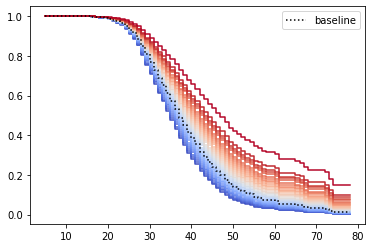

In [ ]:
yard_values = scramble_plays_wo_PA.yardsToGo.sort_values().unique()
cph.plot_partial_effects_on_outcome(covariates='yardsToGo', values=yard_values, cmap='coolwarm', 
    legend=False
)


# Time-varying Cox model 

In [ ]:
from lifelines.utils import to_long_format, add_covariate_to_timeline

df_dataset = scramble_plays_wo_PA.loc[:, ['playId','duration', 'death', 'down', 'yardsToGo', 'defendersInBox']]
df_dataset = df_dataset[df_dataset.playId.isin(df_area_t.playId.unique())]
df_area_t = df_area_t[['playId', 'frameId', 'Area']]
base_df = to_long_format(df_dataset, duration_col='duration')

df_final = add_covariate_to_timeline(base_df, df_area_t, duration_col="frameId", id_col="playId", event_col="death")
df_final = df_final.dropna()
df_final

,start,Area,defendersInBox,down,yardsToGo,stop,playId,death
3,1,25.18850,8.0,1.0,10.0,2.0,55,False
4,2,25.18850,8.0,1.0,10.0,3.0,55,False
5,3,25.18850,8.0,1.0,10.0,4.0,55,False
6,4,25.18850,8.0,1.0,10.0,5.0,55,False
7,5,25.18920,8.0,1.0,10.0,6.0,55,False
...,...,...,...,...,...,...,...,...
26142,9,27.41085,7.0,3.0,10.0,10.0,4772,False
26143,10,27.29630,7.0,3.0,10.0,11.0,4772,False
26144,11,27.10555,7.0,3.0,10.0,12.0,4772,False
26145,12,27.22510,7.0,3.0,10.0,13.0,4772,False


In [ ]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(df_final, id_col="playId", event_col="death", start_col="start", stop_col="stop", show_progress=True)
ctv.print_summary()

Iteration 1: norm_delta = 0.00954, step_size = 0.95000, ll = -875.81035, newton_decrement = 0.13383, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00048, step_size = 0.95000, ll = -875.67682, newton_decrement = 0.00034, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00002, step_size = 0.95000, ll = -875.67648, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00000, step_size = 1.00000, ll = -875.67648, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 4 iterations.


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxTimeVaryingFitter: fitted with 24321 periods, 935 subjects, 184 events>
         event col = 'death'
         penalizer = 0.1
number of subjects = 935
 number of periods = 24321
  number of events = 184
partial log-likelihood = -875.68
  time fit was run = 2022-12-11 19:10:02 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Area            -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
defendersInBox  -0.01       0.99       0.02            -0.05             0.04                 0.95                 1.04
down             0.01       1.01       0.02            -0.04             0.05                 0.96                 1.05
yardsToGo       -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01

                 cmp to     z    p   -log2(p)
covariate                                    
Area               0.00 -0.35 0.72       0.46
defendersInBox     0.00 -0.26 0.80       0.33
down               0.00  0.26 0.79       0.33
yardsToGo          0.00 -0.14 0.89       0.16
---
Partial AIC = 1759.35
log-likelihood ratio test = 0.27 on 4 df
-log2(p) of ll-ratio test = 0.01

In [ ]:
ctv.predict_survival_function()


AttributeError: 'CoxTimeVaryingFitter' object has no attribute 'predict_survival_function'